# Event Detection Via Social Media Data
----

## Data Loading

In [1]:
#@title Fix Dependency Issue
# Uninstall potentially conflicting versions first
# !pip uninstall -y numpy scipy gensim fasttext bertopic laserembeddings sentence-transformers

# !pip install numpy==1.26.4 scipy=
# !pip install gensim
# !pip install fasttext
# !pip install laserembeddings
!pip install bertopic
!pip install sentence-transformers
!pip install gensim


In [2]:
#@title Install Packages
# !pip install arabic-reshaper python-bidi
# !pip install ar_wordcloud
# !pip install transformers
# # !pip install stanza --quiet
# !pip install -U bertopic
# !pip install -U sentence-transformers
# !pip install -U scikit-learn
# !pip install -U arabert

# import nltk
# # import stanza

# nltk.download('stopwords')
# from nltk.corpus import stopwords

# arabic_stopwords = set(stopwords.words('arabic'))

# english_stopwords = set(stopwords.words('english'))
# combined_stopwords = arabic_stopwords.union(english_stopwords)

# # Download Arabic model once
# # stanza.download('ar', verbose=False)

# # Initialize pipeline for Arabic with NER
# # nlp = stanza.Pipeline('ar', processors='tokenize,ner', use_gpu=True)


In [3]:
#@title import packages
import numpy as np
import requests
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score
import re
import ast

# For reproducibility
np.random.seed(42)

import pandas as pd
#@title import packages
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
# import arabic_reshaper
# from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
# import arabic_reshaper
# from bidi.algorithm import get_display
from collections import Counter
import ast
# import arabic_reshaper
# from bidi.algorithm import get_display
# from ar_wordcloud import ArabicWordCloud

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import networkx as nx


In [4]:
#@title uitlities
import re

def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+', '', text)                # remove mentions
    text = re.sub(r'#\w+', '', text)                # remove hashtags
    text = re.sub(r'[^ء-يa-zA-Z0-9\s]', ' ', text) # keep Arabic letters, Latin letters, numbers, and spaces only
    text = re.sub(r'\s+', ' ', text)                 # remove extra whitespace
    return text.strip()

def extract_entities_stanza(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities




In [5]:
# @title Define Constants
urls = [
    "https://raw.githubusercontent.com/HasanKhadd0ur/SocialED_datasets/main/npy_data/Event2012.npy"
]
from google.colab import drive
drive.mount('/content/drive')

columns=[ 'tweet_id', 'text', 'event_id', 'words', 'filtered_words', 'entities', 'user_id', 'created_at', 'urls', 'hashtags', 'user_mentions']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#@title process data
# import os
# import pandas as pd

# # Define folder path in your Drive
# folder_path = '/content/drive/MyDrive/Events'

# # List CSV files only
# csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
# dataframes = []

# for label, filename in enumerate(csv_files):
#     file_path = os.path.join(folder_path, filename)
#     try:
#         df = pd.read_csv(file_path)
#         df['event_label'] = label  # Numeric label for each file
#         df['event_filename'] = filename  # Optional: store filename
#         dataframes.append(df)
#     except Exception as e:
#         print(f"Error reading {filename}: {e}")
# merged_df = pd.concat(dataframes, ignore_index=True)

# # Optional: Save to Drive or download
# merged_df.to_csv('/content/drive/MyDrive/merged_labeled_events.csv', index=False)

In [7]:
#@title Load dataset
df = pd.read_csv("/content/drive/MyDrive/cleaned_merged_labeled_events.csv")

In [8]:
#@title Data Columns
df.columns

Index(['Tweet ID', 'Tweet Text', 'Type', 'Author Name', 'Author Username',
       'Creation Time', 'Reply Count', 'Retweet Count', 'Quote Count',
       'Like Count', 'View Count', 'Bookmark Count', 'Language',
       'Possibly Sensitive', 'Source', 'Hashtags', 'Tweet URL', 'Media Type',
       'Media URLs', 'External URLs', 'event_label', 'event_filename',
       'Hashtags_str', 'Old Tweet Text', 'Date', 'Block', 'duration_days',
       'duration_hours', 'duration_minutes', 'Named Entities', 'PER', 'ORG',
       'LOC', 'date', 'arabert_embeddings'],
      dtype='object')

In [9]:
# @title Ensure Type
# Ensure datetime format
df['Creation Time'] = pd.to_datetime(df['Creation Time'])
# Extract just the date part
df['date'] = df['Creation Time'].dt.date

import ast

def entities_to_list(entities_str):
    if isinstance(entities_str, str):
        try:
            # Safely evaluate the string to a Python list
            entities = ast.literal_eval(entities_str)
            # Ensure it's a list and strip whitespace from each entity
            if isinstance(entities, list):
                return [e.strip() for e in entities]
            else:
                return []
        except (ValueError, SyntaxError):
            return []
    else:
        return []
# convert the embedding fro type str to type ndarray
df['arabert_embeddings']=df['arabert_embeddings'].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))

# Apply to the Named Entities column
# df['Named Entities'] = df['Named Entities'].apply(entities_to_list)



In [10]:
#@title Ensure hashtags are stored as lists instead of comma-separated strings
# def convert_hashtags_to_list(value):
#     if isinstance(value, str):
#         return [tag.strip() for tag in value.split(',') if tag.strip()]
#     return []

# df['Hashtags'] = df['Hashtags'].apply(convert_hashtags_to_list)
# Convert the string of hashtags separated by commas into a list, handling NaN

def hashtags_to_list(hstring):
    if isinstance(hstring, str):
        # Split by comma, strip whitespace
      return [tag.strip().lstrip('#') for tag in hstring.split(',') if tag.strip()]

    else:
        # For NaN or missing values
        return []
df['Hashtags_str'] = df['Hashtags']

# Apply conversion to your hashtag column, e.g., 'Hashtags_str'
df['Hashtags'] = df['Hashtags'].apply(hashtags_to_list)



In [11]:
# @title Data shape
print(df.shape)


(6998, 35)


In [12]:
#@title Clean the tweet texts
df['Old Tweet Text'] = df['Tweet Text']
df['Tweet Text'] = df['Tweet Text'].apply(clean_tweet)


In [13]:
#@title Split the Dataset
from datetime import date

# Define the split date
split_date = date(2025, 5, 7)

# Split the dataset
tuning_df = df[df['date'] < split_date].copy()
evaluation_df = df[df['date'] >= split_date].copy()

# Show the sizes
print(f"🧪 Tuning Set Size     : {tuning_df.shape[0]} messages")
print(f"📈 Evaluation Set Size : {evaluation_df.shape[0]} messages")


🧪 Tuning Set Size     : 934 messages
📈 Evaluation Set Size : 6064 messages


## DBSCAN, With ARABERT Embedding

In [13]:
# @title Install  Arabert and BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Use Arabic sentence transformer model
embedding_model = SentenceTransformer("aubmindlab/bert-base-arabertv2")

# Create and fit BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, language="arabic")



config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [14]:
#@title Embeddding the Tweets
tweets = df['Tweet Text'].tolist()
embeddings = embedding_model.encode(tweets, show_progress_bar=True)


Batches:   0%|          | 0/219 [00:00<?, ?it/s]

In [15]:
#@title Save the Embedding
# Convert embeddings to a regular list
df['arabert_embeddings'] = embeddings.tolist()

# # Convert to DataFrame
# embedding_df = pd.DataFrame(embeddings)

# # Save
# embedding_df.to_csv("tweet_embeddings.csv", index=False)


In [19]:
#  @title Load the embedding for the tuning and evaluation df

# Convert list of embeddings (stored as lists) into 2D numpy arrays
tuning_embeddings = np.vstack(tuning_df['arabert_embeddings'].apply(np.array).values)
evaluation_embeddings = np.vstack(evaluation_df['arabert_embeddings'].apply(np.array).values)

print(f"Tuning embeddings shape: {tuning_embeddings.shape}")
print(f"Evaluation embeddings shape: {evaluation_embeddings.shape}")


Tuning embeddings shape: (934, 768)
Evaluation embeddings shape: (6064, 768)


In [14]:

#@title Define range of DBSCAN parameters to tune
# eps_values = np.arange(0.02, 0.15, 0.01)        # Distance threshold
eps_values = np.arange(0.11, 0.15, 0.01)        # Distance threshold
min_samples_values = np.arange(3,10,1)         # Minimum samples in neighborhood
dim_values = [32, 64, 96, 128, 160, 192, 256, 320, 384, 448, 512, 640, 768]
best_score = -1
best_params = None


In [16]:
#@title Analyze the Effect of DBSCAN's epsilon Parameter on Clustering Results
true_labels_tuning = tuning_df['event_label'].values
true_labels_eval = evaluation_df['event_label'].values

results_tuning = []
results_eval = []

# Tune over eps
for eps in eps_values:
    for min_samples in min_samples_values:
        # --- Tuning ---
        dbscan_tuning = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        cluster_labels_tuning = dbscan_tuning.fit_predict(tuning_embeddings)

        if len(set(cluster_labels_tuning)) > 1 and (cluster_labels_tuning != -1).any():
            nmi = normalized_mutual_info_score(true_labels_tuning, cluster_labels_tuning)
            ari = adjusted_rand_score(true_labels_tuning, cluster_labels_tuning)
            ami = adjusted_mutual_info_score(true_labels_tuning, cluster_labels_tuning)
        else:
            nmi = ari = ami = 0

        results_tuning.append({
            'eps': eps,
            'min_samples': min_samples,
            'nmi': nmi,
            'ari': ari,
            'ami': ami
        })

        # --- Evaluation ---
        dbscan_eval = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        cluster_labels_eval = dbscan_eval.fit_predict(evaluation_embeddings)

        if len(set(cluster_labels_eval)) > 1 and (cluster_labels_eval != -1).any():
            nmi_e = normalized_mutual_info_score(true_labels_eval, cluster_labels_eval)
            ari_e = adjusted_rand_score(true_labels_eval, cluster_labels_eval)
            ami_e = adjusted_mutual_info_score(true_labels_eval, cluster_labels_eval)
        else:
            nmi_e = ari_e = ami_e = 0

        results_eval.append({
            'eps': eps,
            'min_samples': min_samples,
            'nmi': nmi_e,
            'ari': ari_e,
            'ami': ami_e
        })

# Convert to DataFrames
df_tuning = pd.DataFrame(results_tuning)
df_eval = pd.DataFrame(results_eval)

# Aggregate over min_samples
agg_tuning = df_tuning.groupby('eps')[['nmi', 'ari', 'ami']].mean().reset_index()
agg_eval = df_eval.groupby('eps')[['nmi', 'ari', 'ami']].mean().reset_index()



Best eps based on NMI (Tuning Set): eps = 0.14, NMI = 0.1780


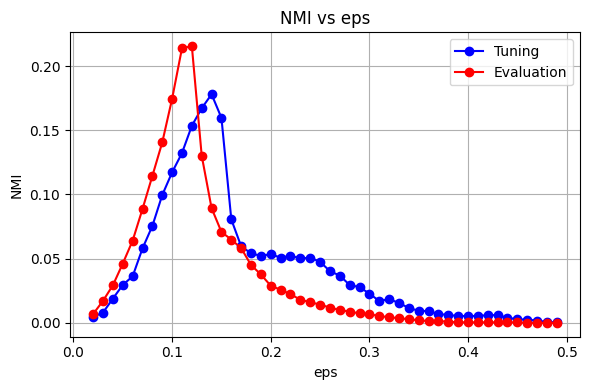

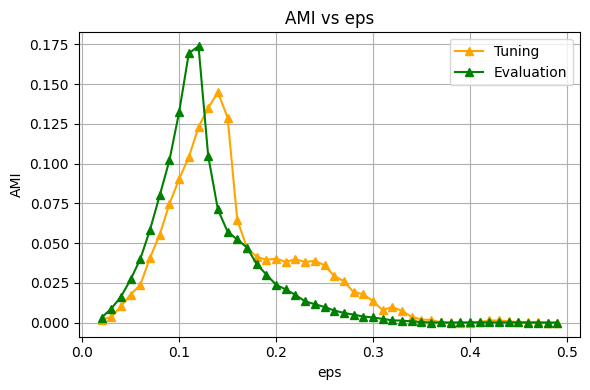

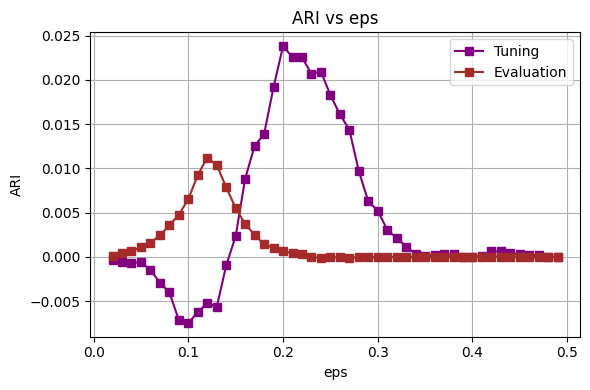

In [19]:
#@title the Effect of DBSCAN's epsilon Parameter on Clustering Result

# Print best eps based on NMI from tuning set
best_eps_row = agg_tuning.loc[agg_tuning['nmi'].idxmax()]
print(f"Best eps based on NMI (Tuning Set): eps = {best_eps_row['eps']:.2f}, NMI = {best_eps_row['nmi']:.4f}")

# === Plot NMI ===
plt.figure(figsize=(6, 4))
plt.plot(agg_tuning['eps'], agg_tuning['nmi'], marker='o', color='blue', label='Tuning')
plt.plot(agg_eval['eps'], agg_eval['nmi'], marker='o', color='red', label='Evaluation')
plt.title('NMI vs eps')
plt.xlabel('eps')
plt.ylabel('NMI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot AMI ===
plt.figure(figsize=(6, 4))
plt.plot(agg_tuning['eps'], agg_tuning['ami'], marker='^', color='orange', label='Tuning')
plt.plot(agg_eval['eps'], agg_eval['ami'], marker='^', color='green', label='Evaluation')
plt.title('AMI vs eps')
plt.xlabel('eps')
plt.ylabel('AMI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot ARI ===
plt.figure(figsize=(6, 4))
plt.plot(agg_tuning['eps'], agg_tuning['ari'], marker='s', color='purple', label='Tuning')
plt.plot(agg_eval['eps'], agg_eval['ari'], marker='s', color='brown', label='Evaluation')
plt.title('ARI vs eps')
plt.xlabel('eps')
plt.ylabel('ARI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
#@title Analyze the Effect of DBSCAN's Min Samples   Parameter on Clustering Result

true_labels_tuning = tuning_df['event_label'].values
true_labels_eval = evaluation_df['event_label'].values

results_tuning = []
results_eval = []

# Iterate over eps and min_samples combinations
for eps in eps_values:
    for min_samples in min_samples_values:
        # --- Tuning ---
        dbscan_tuning = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        cluster_labels_tuning = dbscan_tuning.fit_predict(tuning_embeddings)

        if len(set(cluster_labels_tuning)) > 1 and (cluster_labels_tuning != -1).any():
            nmi = normalized_mutual_info_score(true_labels_tuning, cluster_labels_tuning)
            ari = adjusted_rand_score(true_labels_tuning, cluster_labels_tuning)
            ami = adjusted_mutual_info_score(true_labels_tuning, cluster_labels_tuning)
        else:
            nmi = ari = ami = 0

        results_tuning.append({
            'eps': eps,
            'min_samples': min_samples,
            'nmi': nmi,
            'ari': ari,
            'ami': ami
        })

        # --- Evaluation ---
        dbscan_eval = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        cluster_labels_eval = dbscan_eval.fit_predict(evaluation_embeddings)

        if len(set(cluster_labels_eval)) > 1 and (cluster_labels_eval != -1).any():
            nmi_e = normalized_mutual_info_score(true_labels_eval, cluster_labels_eval)
            ari_e = adjusted_rand_score(true_labels_eval, cluster_labels_eval)
            ami_e = adjusted_mutual_info_score(true_labels_eval, cluster_labels_eval)
        else:
            nmi_e = ari_e = ami_e = 0

        results_eval.append({
            'eps': eps,
            'min_samples': min_samples,
            'nmi': nmi_e,
            'ari': ari_e,
            'ami': ami_e
        })

# Convert to DataFrames
df_tuning = pd.DataFrame(results_tuning)
df_eval = pd.DataFrame(results_eval)

# === Aggregate over eps to study the effect of min_samples ===
agg_tuning_min = df_tuning.groupby('min_samples')[['nmi', 'ari', 'ami']].mean().reset_index()
agg_eval_min = df_eval.groupby('min_samples')[['nmi', 'ari', 'ami']].mean().reset_index()



Best min_samples based on NMI (Tuning Set): min_samples = 3, NMI = 0.1812


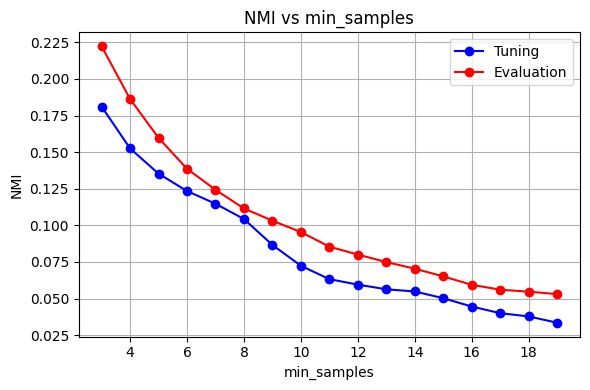

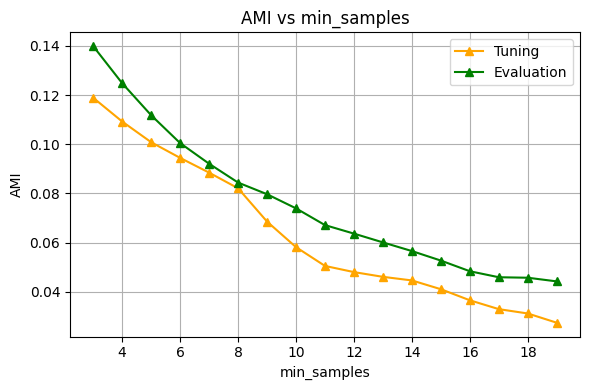

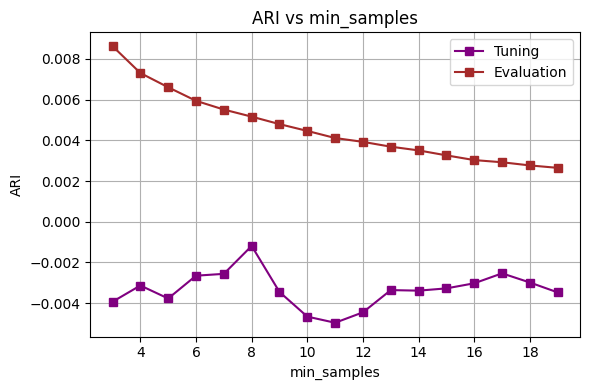

In [24]:
#@title Analyze the Effect of DBSCAN's Min Samples   Parameter on Clustering Result

# Print best min_samples based on NMI from tuning set
best_minsample_row = agg_tuning_min.loc[agg_tuning_min['nmi'].idxmax()]
print(f"Best min_samples based on NMI (Tuning Set): min_samples = {int(best_minsample_row['min_samples'])}, NMI = {best_minsample_row['nmi']:.4f}")

# === Plot NMI ===
plt.figure(figsize=(6, 4))
plt.plot(agg_tuning_min['min_samples'], agg_tuning_min['nmi'], marker='o', color='blue', label='Tuning')
plt.plot(agg_eval_min['min_samples'], agg_eval_min['nmi'], marker='o', color='red', label='Evaluation')
plt.title('NMI vs min_samples')
plt.xlabel('min_samples')
plt.ylabel('NMI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot AMI ===
plt.figure(figsize=(6, 4))
plt.plot(agg_tuning_min['min_samples'], agg_tuning_min['ami'], marker='^', color='orange', label='Tuning')
plt.plot(agg_eval_min['min_samples'], agg_eval_min['ami'], marker='^', color='green', label='Evaluation')
plt.title('AMI vs min_samples')
plt.xlabel('min_samples')
plt.ylabel('AMI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot ARI ===
plt.figure(figsize=(6, 4))
plt.plot(agg_tuning_min['min_samples'], agg_tuning_min['ari'], marker='s', color='purple', label='Tuning')
plt.plot(agg_eval_min['min_samples'], agg_eval_min['ari'], marker='s', color='brown', label='Evaluation')
plt.title('ARI vs min_samples')
plt.xlabel('min_samples')
plt.ylabel('ARI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
#@title Analyze the Effect of PCA Dimensionality Reduction on DBSCAN Clustering Result

from sklearn.decomposition import PCA
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN

# --- Settings ---

dim_values = [32, 64, 96, 128, 160, 192, 256, 320, 384, 448, 512, 640, 768]
eps_best = 0.14
min_samples_best = 3

# True labels
true_labels_tuning = tuning_df['event_label'].values
true_labels_eval = evaluation_df['event_label'].values

dim_results = []

for dim in dim_values:
    # Reduce embeddings
    pca = PCA(n_components=dim)
    reduced_tuning = pca.fit_transform(tuning_embeddings)
    reduced_eval = pca.transform(evaluation_embeddings)

    # --- Tuning clustering ---
    dbscan_tuning = DBSCAN(eps=eps_best, min_samples=min_samples_best, metric='cosine')
    cluster_tuning = dbscan_tuning.fit_predict(reduced_tuning)

    if len(set(cluster_tuning)) > 1 and (cluster_tuning != -1).any():
        nmi = normalized_mutual_info_score(true_labels_tuning, cluster_tuning)
        ari = adjusted_rand_score(true_labels_tuning, cluster_tuning)
        ami = adjusted_mutual_info_score(true_labels_tuning, cluster_tuning)
    else:
        nmi = ari = ami = 0

    # --- Eval clustering ---
    dbscan_eval = DBSCAN(eps=eps_best, min_samples=min_samples_best, metric='cosine')
    cluster_eval = dbscan_eval.fit_predict(reduced_eval)

    if len(set(cluster_eval)) > 1 and (cluster_eval != -1).any():
        nmi_e = normalized_mutual_info_score(true_labels_eval, cluster_eval)
        ari_e = adjusted_rand_score(true_labels_eval, cluster_eval)
        ami_e = adjusted_mutual_info_score(true_labels_eval, cluster_eval)
    else:
        nmi_e = ari_e = ami_e = 0

    dim_results.append({
        'dim': dim,
        'nmi_tuning': nmi,
        'ari_tuning': ari,
        'ami_tuning': ami,
        'nmi_eval': nmi_e,
        'ari_eval': ari_e,
        'ami_eval': ami_e
    })

# Convert to DataFrame
dim_df = pd.DataFrame(dim_results)


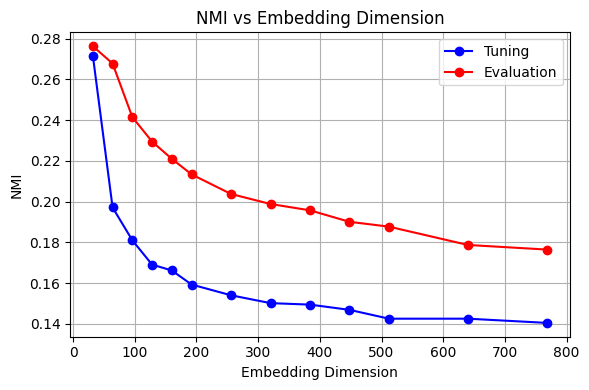

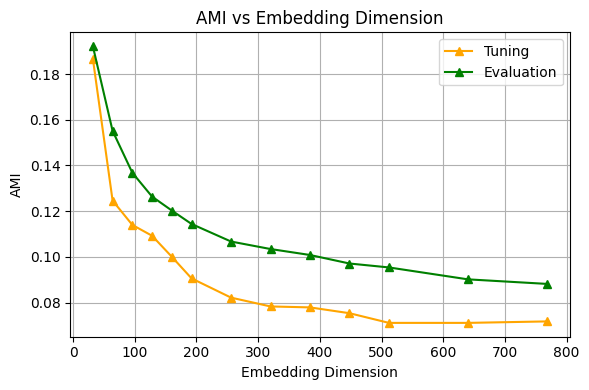

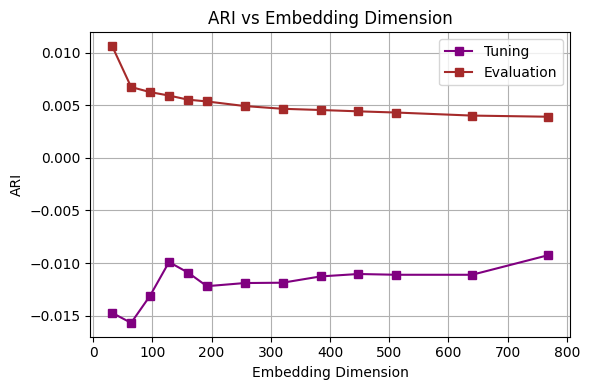

In [36]:
#@title the Effect of PCA Dimensionality Reduction on DBSCAN Clustering Performance

# === Plot NMI ===
plt.figure(figsize=(6, 4))
plt.plot(dim_df['dim'], dim_df['nmi_tuning'], marker='o', label='Tuning', color='blue')
plt.plot(dim_df['dim'], dim_df['nmi_eval'], marker='o', label='Evaluation', color='red')
plt.title('NMI vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('NMI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot AMI ===
plt.figure(figsize=(6, 4))
plt.plot(dim_df['dim'], dim_df['ami_tuning'], marker='^', label='Tuning', color='orange')
plt.plot(dim_df['dim'], dim_df['ami_eval'], marker='^', label='Evaluation', color='green')
plt.title('AMI vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('AMI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot ARI ===
plt.figure(figsize=(6, 4))
plt.plot(dim_df['dim'], dim_df['ari_tuning'], marker='s', label='Tuning', color='purple')
plt.plot(dim_df['dim'], dim_df['ari_eval'], marker='s', label='Evaluation', color='brown')
plt.title('ARI vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('ARI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:

#@title Grid search on tuning set
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import DBSCAN
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score

# Parameters for grid search
reducers = {
    'PCA': PCA,
    'UMAP': UMAP
}

true_labels_tuning = tuning_df['event_label'].values
true_labels_eval = evaluation_df['event_label'].values

results = []

# Grid search on tuning set
for reducer_name, reducer_cls in reducers.items():
    for dim in dim_values:
        print(f"Reducing tuning data to {dim}D using {reducer_name}...")
        reducer = reducer_cls(n_components=dim, random_state=42)
        reduced_tuning = reducer.fit_transform(tuning_embeddings)

        for eps in eps_values:
            for min_samples in min_samples_values:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
                cluster_labels = dbscan.fit_predict(reduced_tuning)

                if len(set(cluster_labels)) > 1 and (cluster_labels != -1).any():
                    nmi = normalized_mutual_info_score(true_labels_tuning, cluster_labels)
                    ari = adjusted_rand_score(true_labels_tuning, cluster_labels)
                    ami = adjusted_mutual_info_score(true_labels_tuning, cluster_labels)
                else:
                    nmi = ari = ami = 0

                results.append({
                    'reducer': reducer_name,
                    'dim': dim,
                    'eps': eps,
                    'min_samples': min_samples,
                    'nmi': nmi,
                    'ari': ari,
                    'ami': ami,
                    'reduced_tuning': reduced_tuning
                })

results_df = pd.DataFrame(results)


Reducing tuning data to 32D using PCA...
Reducing tuning data to 64D using PCA...
Reducing tuning data to 96D using PCA...
Reducing tuning data to 128D using PCA...
Reducing tuning data to 160D using PCA...
Reducing tuning data to 192D using PCA...
Reducing tuning data to 256D using PCA...
Reducing tuning data to 320D using PCA...
Reducing tuning data to 384D using PCA...
Reducing tuning data to 448D using PCA...
Reducing tuning data to 512D using PCA...
Reducing tuning data to 640D using PCA...
Reducing tuning data to 768D using PCA...
Reducing tuning data to 32D using UMAP...
Reducing tuning data to 64D using UMAP...
Reducing tuning data to 96D using UMAP...
Reducing tuning data to 128D using UMAP...
Reducing tuning data to 160D using UMAP...
Reducing tuning data to 192D using UMAP...
Reducing tuning data to 256D using UMAP...
Reducing tuning data to 320D using UMAP...
Reducing tuning data to 384D using UMAP...
Reducing tuning data to 448D using UMAP...
Reducing tuning data to 512D u

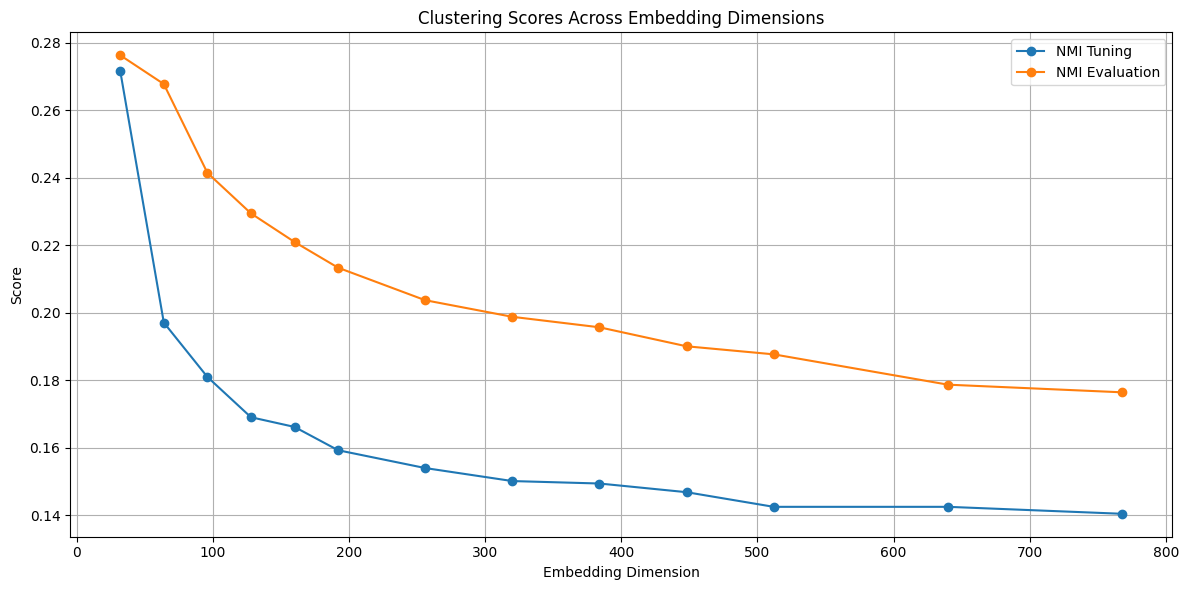

In [38]:
#@title Nmi vs  Dim
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot NMI
plt.plot(dim_df['dim'], dim_df['nmi_tuning'], label='NMI Tuning', marker='o')
plt.plot(dim_df['dim'], dim_df['nmi_eval'], label='NMI Evaluation', marker='o')

# # Plot ARI
# plt.plot(dim_df['dim'], dim_df['ari_tuning'], label='ARI Tuning', marker='s')
# plt.plot(dim_df['dim'], dim_df['ari_eval'], label='ARI Evaluation', marker='s')

# # Plot AMI
# plt.plot(dim_df['dim'], dim_df['ami_tuning'], label='AMI Tuning', marker='^')
# plt.plot(dim_df['dim'], dim_df['ami_eval'], label='AMI Evaluation', marker='^')

plt.title('Clustering Scores Across Embedding Dimensions')
plt.xlabel('Embedding Dimension')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
#@title Best Params
# Get best tuning config by NMI
best_config = results_df.loc[results_df['nmi'].idxmax()]
print("Best NMI config on tuning set:")
print(best_config[['reducer', 'dim', 'eps', 'min_samples', 'nmi', 'ari', 'ami']])

# Using best config, transform evaluation embeddings and evaluate clustering
best_reducer_cls = reducers[best_config['reducer']]
best_dim = best_config['dim']
best_eps = best_config['eps']
best_min_samples = best_config['min_samples']

reducer = best_reducer_cls(n_components=best_dim, random_state=42)
reduced_tuning_best = reducer.fit_transform(tuning_embeddings)
reduced_eval_best = reducer.transform(evaluation_embeddings)

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine')

cluster_labels_tuning = dbscan.fit_predict(reduced_tuning_best)
cluster_labels_eval = dbscan.fit_predict(reduced_eval_best)

def safe_scores(true, pred):
    if len(set(pred)) > 1 and (pred != -1).any():
        nmi = normalized_mutual_info_score(true, pred)
        ari = adjusted_rand_score(true, pred)
        ami = adjusted_mutual_info_score(true, pred)
    else:
        nmi = ari = ami = 0
    return nmi, ari, ami

nmi_tuning, ari_tuning, ami_tuning = safe_scores(true_labels_tuning, cluster_labels_tuning)
nmi_eval, ari_eval, ami_eval = safe_scores(true_labels_eval, cluster_labels_eval)

print("\nEvaluation metrics with best tuning config:")
print(f"NMI: {nmi_eval:.4f}, ARI: {ari_eval:.4f}, AMI: {ami_eval:.4f}")

# Summarize metrics for each dimension using best eps and min_samples
dim_metrics = []



Best NMI config on tuning set:
reducer             PCA
dim                  32
eps                0.14
min_samples           3
nmi            0.272896
ari           -0.014109
ami            0.188416
Name: 21, dtype: object

Evaluation metrics with best tuning config:
NMI: 0.2734, ARI: 0.0104, AMI: 0.1881


In [40]:
#@title Summarize clustering scores across embedding dimensions for best tuning hyperparameters

dim_metrics = []

for dim in dim_values:
    # Initialize reducer with the current dimension
    reducer = best_reducer_cls(n_components=dim, random_state=42)

    # Fit transform tuning embeddings and transform evaluation embeddings
    reduced_tuning = reducer.fit_transform(tuning_embeddings)
    reduced_eval = reducer.transform(evaluation_embeddings)

    # Initialize DBSCAN with best hyperparameters from tuning
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine')

    # Predict cluster labels on tuning and evaluation sets
    labels_tuning = dbscan.fit_predict(reduced_tuning)
    labels_eval = dbscan.fit_predict(reduced_eval)

    # Compute scores safely
    nmi_t, ari_t, ami_t = safe_scores(true_labels_tuning, labels_tuning)
    nmi_e, ari_e, ami_e = safe_scores(true_labels_eval, labels_eval)

    # Append results
    dim_metrics.append({
        'dim': dim,
        'nmi_tuning': nmi_t,
        'ari_tuning': ari_t,
        'ami_tuning': ami_t,
        'nmi_eval': nmi_e,
        'ari_eval': ari_e,
        'ami_eval': ami_e
    })

# Create DataFrame for easier visualization
dim_df = pd.DataFrame(dim_metrics)

print("\nSummary of clustering metrics across embedding dimensions:")
print(dim_df.to_string(index=False))



Summary of clustering metrics across embedding dimensions:
 dim  nmi_tuning  ari_tuning  ami_tuning  nmi_eval  ari_eval  ami_eval
  32    0.272896   -0.014109    0.188416  0.273353  0.010420  0.188119
  64    0.197131   -0.015677    0.124616  0.268647  0.006749  0.155844
  96    0.179197   -0.011349    0.114640  0.239374  0.006202  0.135622
 128    0.169089   -0.009900    0.109222  0.227817  0.005871  0.125949
 160    0.166214   -0.010893    0.100030  0.219837  0.005514  0.119515
 192    0.159310   -0.012190    0.090569  0.212752  0.005383  0.114276
 256    0.154028   -0.011892    0.082150  0.203822  0.004896  0.106583
 320    0.150174   -0.011861    0.078290  0.198321  0.004640  0.103009
 384    0.149446   -0.011264    0.077876  0.195147  0.004538  0.100663
 448    0.146875   -0.011033    0.075330  0.190559  0.004453  0.098121
 512    0.142537   -0.011106    0.071095  0.187236  0.004286  0.094921
 640    0.142537   -0.011106    0.071095  0.178736  0.004016  0.090148
 768    0.140474 

In [41]:
#@title The Results of the Clustering
dim_metrics = []

for dim in dim_values:
    reducer = best_reducer_cls(n_components=dim, random_state=42)
    reduced_tuning = reducer.fit_transform(tuning_embeddings)
    reduced_eval = reducer.transform(evaluation_embeddings)

    print(f"Using eps = {best_eps}, min_samples = {best_min_samples} for dim = {dim}")

    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine')

    labels_tuning = dbscan.fit_predict(reduced_tuning)
    labels_eval = dbscan.fit_predict(reduced_eval)

    nmi_t, ari_t, ami_t = safe_scores(true_labels_tuning, labels_tuning)
    nmi_e, ari_e, ami_e = safe_scores(true_labels_eval, labels_eval)

    dim_metrics.append({
        'dim': dim,
        'nmi_tuning': nmi_t,
        'ari_tuning': ari_t,
        'ami_tuning': ami_t,
        'nmi_eval': nmi_e,
        'ari_eval': ari_e,
        'ami_eval': ami_e
    })

dim_df = pd.DataFrame(dim_metrics)

print("\nSummary of metrics across embedding dimensions:")
print(dim_df.to_string(index=False))


Using eps = 0.13999999999999999, min_samples = 3 for dim = 32
Using eps = 0.13999999999999999, min_samples = 3 for dim = 64
Using eps = 0.13999999999999999, min_samples = 3 for dim = 96
Using eps = 0.13999999999999999, min_samples = 3 for dim = 128
Using eps = 0.13999999999999999, min_samples = 3 for dim = 160
Using eps = 0.13999999999999999, min_samples = 3 for dim = 192
Using eps = 0.13999999999999999, min_samples = 3 for dim = 256
Using eps = 0.13999999999999999, min_samples = 3 for dim = 320
Using eps = 0.13999999999999999, min_samples = 3 for dim = 384
Using eps = 0.13999999999999999, min_samples = 3 for dim = 448
Using eps = 0.13999999999999999, min_samples = 3 for dim = 512
Using eps = 0.13999999999999999, min_samples = 3 for dim = 640
Using eps = 0.13999999999999999, min_samples = 3 for dim = 768

Summary of metrics across embedding dimensions:
 dim  nmi_tuning  ari_tuning  ami_tuning  nmi_eval  ari_eval  ami_eval
  32    0.272896   -0.014109    0.188416  0.273353  0.010420  0.

In [42]:
#@title Clustering and Topic Modeling Metrics Summary Across Embedding Dimensions
from sklearn.metrics import silhouette_score
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def safe_silhouette_score(X, labels):
    if len(set(labels)) > 1 and len(X) > len(set(labels)):
        return silhouette_score(X, labels, metric='cosine')
    return -1

def get_topic_coherence(texts, labels, coherence_type='c_v'):
    clustered_docs = {}
    for text, label in zip(texts, labels):
        if label == -1:
            continue
        clustered_docs.setdefault(label, []).append(text)

    topics = [docs for docs in clustered_docs.values() if len(docs) >= 3]

    if len(topics) == 0:
        return -1

    tokenized_topics = [[word for doc in topic for word in doc.split()] for topic in topics]

    dictionary = Dictionary(tokenized_topics)
    corpus = [dictionary.doc2bow(text) for text in tokenized_topics]

    coherence_model = CoherenceModel(
        topics=tokenized_topics,
        texts=tokenized_topics,
        corpus=corpus,
        dictionary=dictionary,
        coherence=coherence_type
    )

    return coherence_model.get_coherence()

# Ground truth number of events (true clusters)
true_events_tuning = len(set(tuning_df['event_label']))
true_events_eval = len(set(evaluation_df['event_label']))

# Initialize list for metrics
additional_metrics = []

for dim in dim_values:
    reducer = best_reducer_cls(n_components=dim, random_state=42)
    reduced_tuning = reducer.fit_transform(tuning_embeddings)
    reduced_eval = reducer.transform(evaluation_embeddings)

    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine')

    # Tuning
    labels_tuning = dbscan.fit_predict(reduced_tuning)
    silhouette_t = safe_silhouette_score(reduced_tuning, labels_tuning)
    num_clusters_t = len(set(labels_tuning)) - (1 if -1 in labels_tuning else 0)
    coherence_t_cv = get_topic_coherence(tuning_df['Tweet Text'].tolist(), labels_tuning, coherence_type='c_v')
    coherence_t_umass = get_topic_coherence(tuning_df['Tweet Text'].tolist(), labels_tuning, coherence_type='u_mass')

    # Evaluation
    labels_eval = dbscan.fit_predict(reduced_eval)
    silhouette_e = safe_silhouette_score(reduced_eval, labels_eval)
    num_clusters_e = len(set(labels_eval)) - (1 if -1 in labels_eval else 0)
    coherence_e_cv = get_topic_coherence(evaluation_df['Tweet Text'].tolist(), labels_eval, coherence_type='c_v')
    coherence_e_umass = get_topic_coherence(evaluation_df['Tweet Text'].tolist(), labels_eval, coherence_type='u_mass')

    additional_metrics.append({
        'dim': dim,
        'true_events_tuning': true_events_tuning,
        'true_events_eval': true_events_eval,
        'silhouette_tuning': silhouette_t,
        'num_clusters_tuning': num_clusters_t,
        'coherence_tuning_c_v': coherence_t_cv,
        'coherence_tuning_u_mass': coherence_t_umass,
        'silhouette_eval': silhouette_e,
        'num_clusters_eval': num_clusters_e,
        'coherence_eval_c_v': coherence_e_cv,
        'coherence_eval_u_mass': coherence_e_umass
    })

# Merge with original dim_df
extra_df = pd.DataFrame(additional_metrics)
dim_df = pd.merge(dim_df, extra_df, on='dim')

# Display full summary
print("\nSummary of all clustering metrics across embedding dimensions:")
print(dim_df.to_string(index=False))



Summary of all clustering metrics across embedding dimensions:
 dim  nmi_tuning  ari_tuning  ami_tuning  nmi_eval  ari_eval  ami_eval  true_events_tuning  true_events_eval  silhouette_tuning  num_clusters_tuning  coherence_tuning_c_v  coherence_tuning_u_mass  silhouette_eval  num_clusters_eval  coherence_eval_c_v  coherence_eval_u_mass
  32    0.272896   -0.014109    0.188416  0.273353  0.010420  0.188119                  31               103          -0.262887                   27              0.827777                -0.622548        -0.410749                129            0.660711              -0.908921
  64    0.197131   -0.015677    0.124616  0.268647  0.006749  0.155844                  31               103          -0.224249                   20              0.824099                -0.535501        -0.375203                163            0.755690              -1.121093
  96    0.179197   -0.011349    0.114640  0.239374  0.006202  0.135622                  31               103   

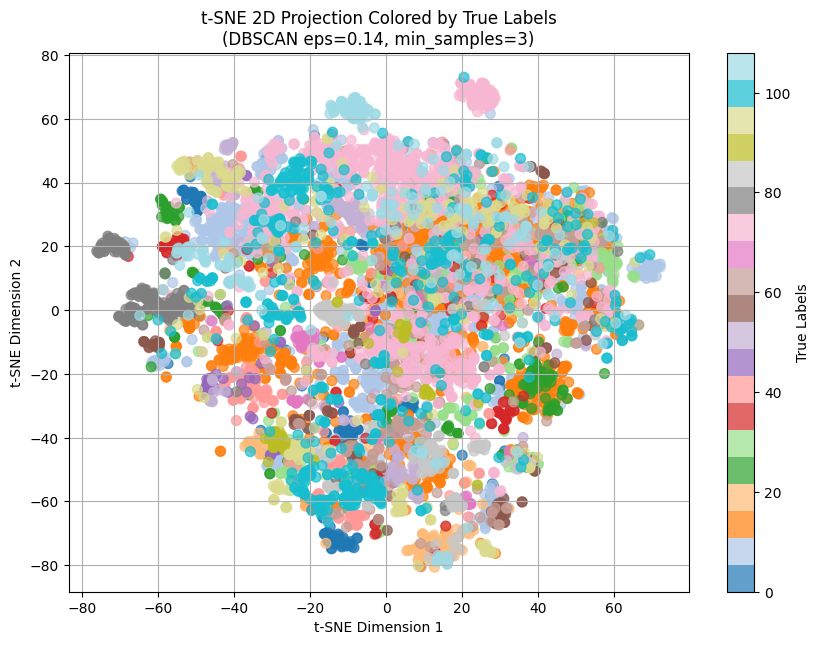

In [24]:
#@title Visualisation
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score

true_labels = evaluation_df['event_label'].values  # Use evaluation labels
best_params_eps=0.14
best_params_min_samples=3

# Run DBSCAN with best params on evaluation embeddings
best_dbscan = DBSCAN(eps=best_params_eps, min_samples=int(best_params_min_samples), metric='cosine')
best_cluster_labels = best_dbscan.fit_predict(evaluation_embeddings)

# t-SNE dimensionality reduction to 2D on evaluation embeddings
tsne = TSNE(n_components=2, random_state=42, init='pca')
reduced_embeddings = tsne.fit_transform(evaluation_embeddings)

# Plotting
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=true_labels, cmap='tab20', alpha=0.7, s=50
)
plt.colorbar(scatter, label='True Labels')
plt.title(f"t-SNE 2D Projection Colored by True Labels\n(DBSCAN eps={best_params_eps:.2f}, min_samples={int(best_params_min_samples)})")
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()
